In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
from laughter_prediction.predictors import RnnPredictor

In [3]:
FRAME_SEC = 0.5
CHUNKS = int(11 / FRAME_SEC)
N_MFCC = 20
N_MELS = 128
FEATURES = N_MFCC + N_MELS

def build_dataset_from_data(data):
    index = data['SNAME'].unique()
    train_index, test_index = train_test_split(index)

    train_data = np.array(data[data['SNAME'].isin(train_index)].drop(columns='SNAME'))
    test_data = np.array(data[data['SNAME'].isin(test_index)].drop(columns='SNAME'))

    X_train = train_data[:, :-1].reshape(len(train_index), CHUNKS, FEATURES)
    y_train = train_data[:, -1].reshape(len(train_index), CHUNKS)
    X_test = test_data[:, :-1].reshape(len(test_index), CHUNKS, FEATURES)
    y_test = test_data[:, -1].reshape(len(test_index), CHUNKS)
    
    return X_train, y_train, X_test, y_test

In [4]:
sampler = SSPNetDataSampler('corpus', 'data')
data = sampler.create_sampled_df(FRAME_SEC, save_path='samples.csv')
data.head()

Sampled data already exists at samples.csv
Skipping generation.


,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V140,V141,V142,V143,V144,V145,V146,V147,IS_LAUGHTER,SNAME
0,903.469993,22.110552,13.151943,46.213083,-17.533179,23.288871,-17.945700,4.478985,-16.021022,-8.827005,...,8.985123e+07,4.989764e+07,4.625960e+07,3.625273e+07,5.107908e+07,7.357580e+07,6.407850e+07,7.800024e+06,0,S1584
1,1076.620915,39.017817,-11.557705,18.714980,-26.330274,4.989787,-18.932455,-9.438138,-15.903813,3.718074,...,9.439361e+08,7.555011e+08,5.229335e+08,5.567003e+08,4.156222e+08,2.205994e+08,1.500357e+08,5.049134e+07,0,S1584
2,995.621771,-1.909144,2.695838,55.443860,-32.991052,-0.126695,-19.138405,3.964841,-24.811939,-17.698905,...,2.482918e+09,1.335233e+09,9.182979e+08,6.711759e+08,4.114660e+08,3.394379e+08,1.120452e+08,1.447846e+07,0,S1584
3,918.134076,59.672153,-6.183980,34.182409,-19.570943,3.922867,-26.072242,-5.724687,-9.738054,-6.946997,...,1.030339e+08,7.779213e+07,3.941465e+07,3.179126e+07,5.402894e+07,9.483624e+07,4.833910e+07,6.200207e+06,0,S1584
4,1030.135489,6.257672,1.848061,15.874738,-24.140455,-0.862834,-24.911275,-0.844526,-8.698000,-2.113416,...,2.005485e+09,1.743934e+09,1.992600e+09,7.783651e+08,6.701162e+08,6.316645e+08,7.908638e+08,1.029155e+08,0,S1584


In [5]:
np.random.seed(7)
X_train, y_train, X_test, y_test = build_dataset_from_data(data)

In [6]:
device = torch.cuda.current_device()
print(torch.cuda.get_device_name(device))

GeForce GTX 1080 Ti


In [7]:
HIDDEN_DIM = 96

def compute_stats(y, y_pred):
    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)
    return acc, auc

In [8]:
predictor = RnnPredictor(FEATURES, HIDDEN_DIM, device)

np.random.seed(7)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(7)

train_losses, test_stats = predictor.train(X_train, y_train, X_test, y_test, fun_compute_stats=compute_stats)
test_accuracies, test_aucs = zip(*test_stats)

100%|██████████| 1000/1000 [00:47<00:00, 21.04it/s]


In [9]:
def smooth(scalars, weight=0.9):
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

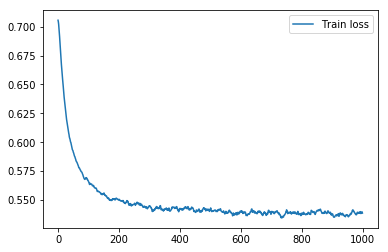

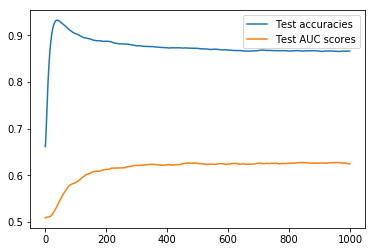

In [10]:
plt.plot(range(len(train_losses)), smooth(train_losses))
plt.legend(['Train loss'])
plt.show()

plt.plot(range(len(test_accuracies)), smooth(test_accuracies))
plt.plot(range(len(test_aucs)), smooth(test_aucs))
plt.legend(['Test accuracies', 'Test AUC scores'])
plt.show()

In [11]:
def plot_test_sample(predictor, X, y):
    y_pred = predictor.predict(X)
    plt.plot(range(len(y)), y, "o")
    plt.plot(range(len(y_pred)), y_pred, 'x')
    plt.legend(['Truth', 'Predicted'])
    plt.show()

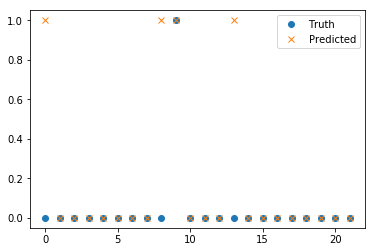

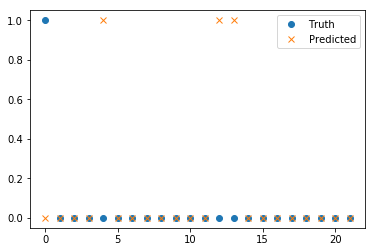

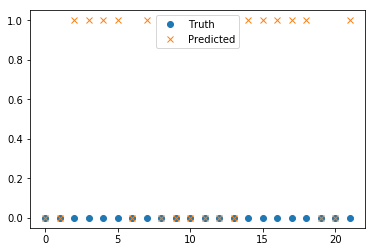

In [12]:
for index in range(3):
    plot_test_sample(predictor, X_test[index], y_test[index])

In [13]:
sampler = SSPNetDataSampler('corpus', 'noised')
noised_data = sampler.create_sampled_df(FRAME_SEC, save_path='noised-samples.csv')
noised_data.head()

Sampled data already exists at noised-samples.csv
Skipping generation.


,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V140,V141,V142,V143,V144,V145,V146,V147,IS_LAUGHTER,SNAME
0,-162.241963,99.305221,-31.083483,9.736183,-5.025057,2.840034,-19.368994,5.831292,-10.526847,8.765844,...,0.000411,0.000324,0.000345,0.000400,0.000373,0.000467,0.000232,0.000014,0,S1450
1,25.870699,76.026166,-24.713012,21.309417,-6.417149,-3.529695,-20.876398,-4.841533,-7.722054,12.752993,...,0.166901,0.093145,0.093664,0.080839,0.090909,0.111359,0.047348,0.012938,0,S1450
2,2.218733,83.199375,-20.165513,33.544626,-12.667571,-6.678504,-16.746280,4.253116,-18.140451,-0.790518,...,0.069084,0.092884,0.081155,0.083733,0.052746,0.050653,0.029799,0.005830,0,S1450
3,-159.205436,102.373750,-11.264694,6.162660,-8.452955,6.778036,-26.255784,3.853356,-10.376898,12.551957,...,0.000679,0.000681,0.000577,0.000658,0.000637,0.000567,0.000275,0.000021,0,S1450
4,-189.015089,111.716419,-13.015388,18.557473,-4.599727,-6.264247,-20.157787,-5.440594,-11.036971,8.762326,...,0.000333,0.000344,0.000350,0.000387,0.000325,0.000394,0.000193,0.000015,0,S1450


In [14]:
np.random.seed(7)
X_train_noised, y_train_noised, X_test_noised, y_test_noised = build_dataset_from_data(noised_data)

In [15]:
predictor_from_noised = RnnPredictor(FEATURES, HIDDEN_DIM, device)

np.random.seed(7)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(7)

train_noised_losses, test_noised_stats = predictor.train(
    X_train_noised, y_train_noised, X_test_noised, y_test_noised, fun_compute_stats=compute_stats)
test_noised_accuracies, test_noised_aucs = zip(*test_noised_stats)

100%|██████████| 1000/1000 [00:47<00:00, 21.06it/s]


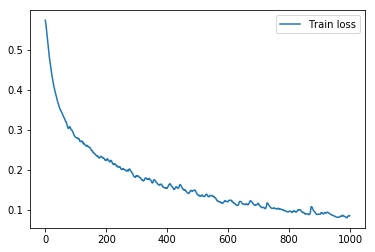

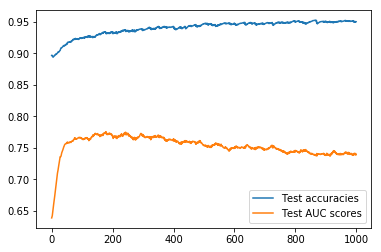

In [16]:
plt.plot(range(len(train_noised_losses)), smooth(train_noised_losses))
plt.legend(['Train loss'])
plt.show()

plt.plot(range(len(test_noised_accuracies)), smooth(test_noised_accuracies))
plt.plot(range(len(test_noised_aucs)), smooth(test_noised_aucs))
plt.legend(['Test accuracies', 'Test AUC scores'])
plt.show()

# Joint results

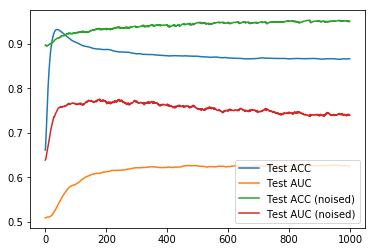

In [17]:
plt.plot(range(len(test_accuracies)), smooth(test_accuracies))
plt.plot(range(len(test_aucs)), smooth(test_aucs))
plt.plot(range(len(test_noised_accuracies)), smooth(test_noised_accuracies))
plt.plot(range(len(test_noised_aucs)), smooth(test_noised_aucs))
plt.legend(['Test ACC', 'Test AUC', 'Test ACC (noised)', 'Test AUC (noised)'])
plt.show()

In [18]:
torch.save(predictor, 'predictor.pkl')